In [17]:
# !pip install -q tensorflow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import os
import shutil
import matplotlib.pyplot as plt

from utils.plots import plot_sample_images, plot_training_history

print("Versão do Tensorflow:")
print(tf.__version__)

Versão do Tensorflow:
2.20.0


# Classificação de Elementos Eletrônicos com TensorFlow e Keras - Tarefa 24

## Carregar dados

Found 10990 files belonging to 36 classes.
Número de classes: 36


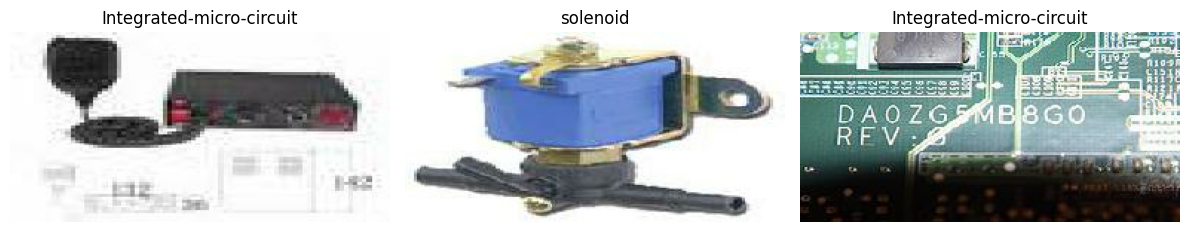

In [18]:
# Configurações
IMG_SIZE = (128, 256)
BATCH_SIZE = 32
SEED = 42

IMAGE_BASE_PATH = "../data/images"

# Carregar TODOS os dados
full_dataset = tf.keras.utils.image_dataset_from_directory(
    IMAGE_BASE_PATH,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
)

# Obter informações
class_names = full_dataset.class_names
num_classes = len(class_names)

print(f"Número de classes: {num_classes}")

# Visualizar amostras do dataset
plot_sample_images(full_dataset, class_names, num_images=3)

## Dividir dados em treino, validação e teste

In [19]:
total_batches = tf.data.experimental.cardinality(full_dataset).numpy()
train_size = int(0.7 * total_batches)
val_size = int(0.15 * total_batches)
test_size = total_batches - train_size - val_size

# Dividir
train_dataset = full_dataset.take(train_size)
remaining = full_dataset.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

print(f"Treino: {train_size} batches")
print(f"Validação: {val_size} batches")
print(f"Teste: {test_size} batches")

# Otimização com AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Após carregar o dataset, adicione normalização
normalization_layer = layers.Rescaling(1./255)

def normalize(image, label):
    return normalization_layer(image), label

# Aplicar nos datasets
train_dataset = train_dataset.map(normalize)
val_dataset = val_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

Treino: 240 batches
Validação: 51 batches
Teste: 53 batches


## Criar o modelo

In [20]:
def build_model(input_shape=(128, 256, 3), num_classes=36):
    """
    Modelo CNN para classificação de componentes eletrônicos
    """
    inputs = keras.Input(shape=input_shape)

    # Normalização dentro do modelo
    x = layers.Rescaling(1./255)(inputs)

    # BLOCO 1
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # BLOCO 2
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # BLOCO 3
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # BLOCO 4
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # CLASSIFICADOR
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="cnn_electronic_components")
    return model

# Criar modelo com número correto de classes
model = build_model(input_shape=(128, 256, 3), num_classes=num_classes)
model.summary()

Model: "cnn_electronic_components"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 128, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 128, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,308,644 (66.03 MB)

 Trainable params: 17,307,684 (66.02 MB)

 Non-trainable params: 960 (3.75 KB)

## Treinar o modelo

In [21]:
# ----------------------------
# TREINAR A CNN
# ----------------------------

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy", keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')]
)

EPOCHS = 30

# Criar pasta para modelos se não existir
os.makedirs('../models', exist_ok=True)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),

    # Salvar melhor modelo automaticamente
    keras.callbacks.ModelCheckpoint(
        filepath='../models/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/30


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0424 - loss: 8.1697 - top5_acc: 0.1827
Epoch 1: val_accuracy improved from None to 0.02880, saving model to ../models/best_model_epoch_01_val_acc_0.03.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.0418 - loss: 5.2820 - top5_acc: 0.1939 - val_accuracy: 0.0288 - val_loss: 4.9035 - val_top5_acc: 0.1618 - learning_rate: 0.0010
Epoch 2/30
178/240 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.0487 - loss: 3.5649 - top5_acc: 0.2138

KeyboardInterrupt: 

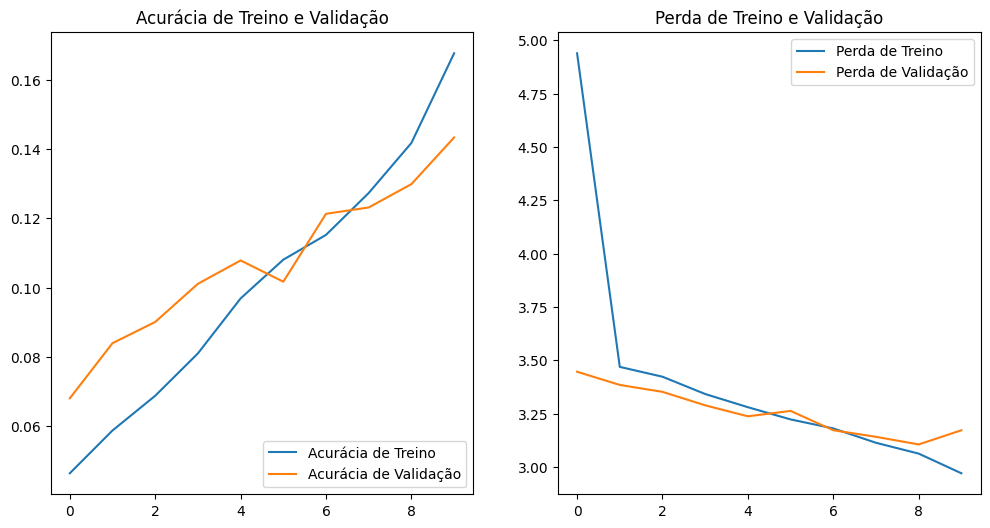

In [ ]:
# ----------------------------
# ACURÁCIA DO TREINAMENTO
# ----------------------------

plot_training_history(history)

# Para carregar o modelo:
# model = keras.models.load_model('../models/cnn_electronic_components.keras')